# work in progress... 

# Classification

Survival prediction of patients with heart failure.

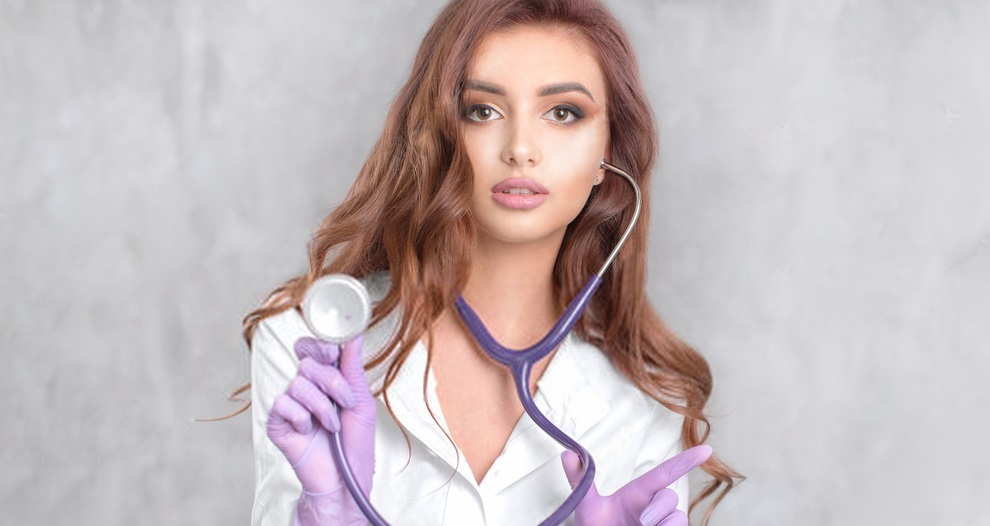

`Data Source: ` [Heart Failure](https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data) 

In this project, we will use a [dataset from Kaggle](https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data) to predict the survival of patients with heart failure from serum creatinine and ejection fraction, and other factors such as age, anemia, diabetes, and so on.

`About The Dataset:`

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worlwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure.

Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

`Data Dictionary:`

1. Feature details

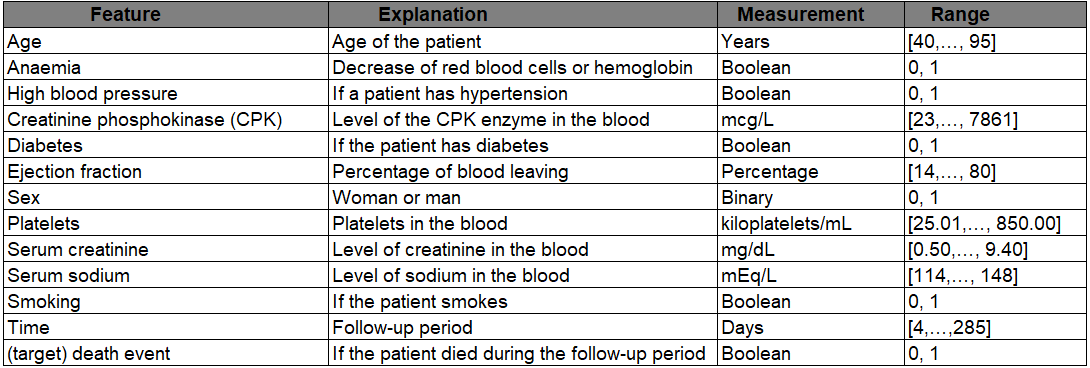

2. Boolean features
   - Sex - 0 = Female, Male = 1
   - Diabetes - 0 = No, 1 = Yes
   - Anaemia - 0 = No, 1 = Yes
   - High_blood_pressure - 0 = No, 1 = Yes
   - Smoking - 0 = No, 1 = Yes
   - DEATH_EVENT - 0 = No, 1 = Yes

3. Other informations
      - mcg/L: micrograms per liter.                  
      - mL: microliter. 
      - mEq/L: milliequivalents per litre
      - The time feature seams to be highly correlated to the death event but there is no concret information of how this               metric was measured patient by patient. Which makes it hard to use it in the analysis.

***

### Load Libraries and Data Inspection

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# from collections import Counter
from tensorflow.keras.utils import to_categorical
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv('heart_failure.csv')
print(df.shape)
df.head()

(299, 15)


,Unnamed: 0,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,death_event
0,0,75.0,no,582,no,20,yes,265000.00,1.9,130,yes,no,4,1,yes
1,1,55.0,no,7861,no,38,no,263358.03,1.1,136,yes,no,6,1,yes
2,2,65.0,no,146,no,20,no,162000.00,1.3,129,yes,yes,7,1,yes
3,3,50.0,yes,111,no,20,no,210000.00,1.9,137,yes,no,7,1,yes
4,4,65.0,yes,160,yes,20,no,327000.00,2.7,116,no,no,8,1,yes


In this dataset, we will use column `death_event` as our class label.

### Class Distribution (death_event) 

Only 32% of our samples failed to survive given of heart failure.

In [3]:
print(df['death_event'].value_counts())
# proportion
df['death_event'].value_counts() / len(df)

no     203
yes     96
Name: death_event, dtype: int64


no     0.67893
yes    0.32107
Name: death_event, dtype: float64

`We have a very small and slightly imbalance dataset`. We can't confidently use accuracy as our scoring method.

`note:` For unbalance dataset we must use recall, precision and f1 for scoring.

`recall:` number of correct prediction out of total Actual Positive. usecase if we need to reduce the False Negative like in cancer detection, we dont want our model to predict a person to be negative while the truth is positive.

`precision:` number of positive in Actual out total Positive prediction. i.e in cases we need to reduce the False Positives like in spam detection, we dont want to predict an important mail to be a spam.

### General Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                299 non-null    int64  
 1   age                       299 non-null    float64
 2   anaemia                   299 non-null    object 
 3   creatinine_phosphokinase  299 non-null    int64  
 4   diabetes                  299 non-null    object 
 5   ejection_fraction         299 non-null    int64  
 6   high_blood_pressure       299 non-null    object 
 7   platelets                 299 non-null    float64
 8   serum_creatinine          299 non-null    float64
 9   serum_sodium              299 non-null    int64  
 10  sex                       299 non-null    object 
 11  smoking                   299 non-null    object 
 12  time                      299 non-null    int64  
 13  DEATH_EVENT               299 non-null    int64  
 14  death_even

Anaemia, diabets, high_blood_pressure, sex, and smoking are in 'str' datatype. In TensorFlow with Keras, we needs to convert all the categorical features and labels into one-hot encoding vectors. 

### Define X and y
Lets define first our class and features. One advantage of Neural Network to traditional Machine Learning algorithm is that we don't need to do a feature selection, Neural Network learn from it's data and adjust features weight accordingly.

In [5]:
y = df['death_event']
# age to smoking
X = df.loc[:,'age':'time']
X.head(3)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,no,582,no,20,yes,265000.00,1.9,130,yes,no,4
1,55.0,no,7861,no,38,no,263358.03,1.1,136,yes,no,6
2,65.0,no,146,no,20,no,162000.00,1.3,129,yes,yes,7


### One-Hot Encoding
One hot encode our X features. Convert categorical features (anaemia, diabets, high_blood_pressure, sex, and smoking are) to one-hot encoding vectors and assign the result back to variable X.

In [6]:
X = pd.get_dummies(X)
X.head(3)

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia_no,anaemia_yes,diabetes_no,diabetes_yes,high_blood_pressure_no,high_blood_pressure_yes,sex_no,sex_yes,smoking_no,smoking_yes
0,75.0,582,20,265000.00,1.9,130,4,1,0,1,0,0,1,0,1,1,0
1,55.0,7861,38,263358.03,1.1,136,6,1,0,1,0,1,0,0,1,1,0
2,65.0,146,20,162000.00,1.3,129,7,1,0,1,0,1,0,0,1,0,1


### Split data
Splitting our train and test data to 70:30 ratio.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 7
                                                   )

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(209, 17) (90, 17) (209,) (90,)


### Standardized 
Standardized our features.

In [8]:
# List of all the numeric features excluding the converter to OHE
ct = ColumnTransformer([("numeric", StandardScaler(), 
                        x_train.columns 
                        )])
print(ct)
x_train = ct.fit_transform(x_train)
x_test = ct.transform(x_test)

ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                 Index(['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium', 'time', 'anaemia_no', 'anaemia_yes',
       'diabetes_no', 'diabetes_yes', 'high_blood_pressure_no',
       'high_blood_pressure_yes', 'sex_no', 'sex_yes', 'smoking_no',
       'smoking_yes'],
      dtype='object'))])


### Label Encoder 
Convert the class/label to integers ranging from 0 to the number of classes.

In [9]:
lencoder = LabelEncoder()
y_train = lencoder.fit_transform(y_train.astype(str)) 
y_test = lencoder.fit_transform(y_test.astype(str))

# Show mapping
class_mapping = {l: i for i, l in enumerate(lencoder.classes_)}
class_mapping

{'no': 0, 'yes': 1}

In [25]:
# Re shape to 2d array
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Designing a Deep Learning Model For Classification

In [28]:
model = Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1],)))
model.add(Dense(12, activation='relu'))
model.add(Dense(2, activation='softmax')) # using softmax, we have two output classes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

### Compile the Model
The model is optimized using the `adam` optimizer and seeks to minimize the `cross-entropy` loss. Using `Recall` as our metric. We need to reduce the False Negative rate because we dont want our model to predict a person to be negative while the truth is positive.

In [29]:
model.compile(loss='binary_crossentropy', metrics=['Recall'], optimizer='adam')

### Early Stopping

In [30]:
# reference https://keras.io/api/callbacks/early_stopping/
stop = EarlyStopping(monitor='val_loss',
                     patience=20,
                     verbose=1)

### Training Phase

In [32]:
# # fix random seed for reproducibility
tf.random.set_seed(7)


h = model.fit(x_train, y_train, 
               validation_data= (x_test, y_test), 
               epochs=100, 
               batch_size= 64,
               verbose=1,
               callbacks=[stop]
             )



Epoch 1/100
4/4 [==============================] - 0s 32ms/step - loss: 0.4081 - recall: 0.8182 - val_loss: 0.4373 - val_recall: 0.8444
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 0.4069 - recall: 0.8182 - val_loss: 0.4364 - val_recall: 0.8444
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 0.4055 - recall: 0.8182 - val_loss: 0.4356 - val_recall: 0.8444
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.4042 - recall: 0.8182 - val_loss: 0.4347 - val_recall: 0.8444
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.4030 - recall: 0.8182 - val_loss: 0.4340 - val_recall: 0.8444
Epoch 6/100
4/4 [==============================] - 0s 9ms/step - loss: 0.4019 - recall: 0.8230 - val_loss: 0.4341 - val_recall: 0.8444
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.4008 - recall: 0.8230 - val_loss: 0.4338 - val_recall: 0.8444
Epoch 8/100
4/4 [==============================] 

Epoch 61/100
4/4 [==============================] - 0s 10ms/step - loss: 0.3601 - recall: 0.8278 - val_loss: 0.4112 - val_recall: 0.8444
Epoch 62/100
4/4 [==============================] - 0s 10ms/step - loss: 0.3597 - recall: 0.8325 - val_loss: 0.4114 - val_recall: 0.8444
Epoch 63/100
4/4 [==============================] - 0s 10ms/step - loss: 0.3589 - recall: 0.8325 - val_loss: 0.4109 - val_recall: 0.8444
Epoch 64/100
4/4 [==============================] - 0s 10ms/step - loss: 0.3585 - recall: 0.8325 - val_loss: 0.4103 - val_recall: 0.8444
Epoch 65/100
4/4 [==============================] - 0s 10ms/step - loss: 0.3580 - recall: 0.8325 - val_loss: 0.4099 - val_recall: 0.8444
Epoch 66/100
4/4 [==============================] - 0s 10ms/step - loss: 0.3576 - recall: 0.8325 - val_loss: 0.4095 - val_recall: 0.8444
Epoch 67/100
4/4 [==============================] - 0s 9ms/step - loss: 0.3569 - recall: 0.8325 - val_loss: 0.4092 - val_recall: 0.8444
Epoch 68/100
4/4 [========================

`Note:` We will get slightly different results if we re-run the training phase multiple times due to algorithm nature of callbacks and validation data.

Consider running the training phase a few times and compare the average outcome.

In [33]:
h.history.keys()

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


### Plotting for Recall Score

Text(0, 0.5, 'Recall')

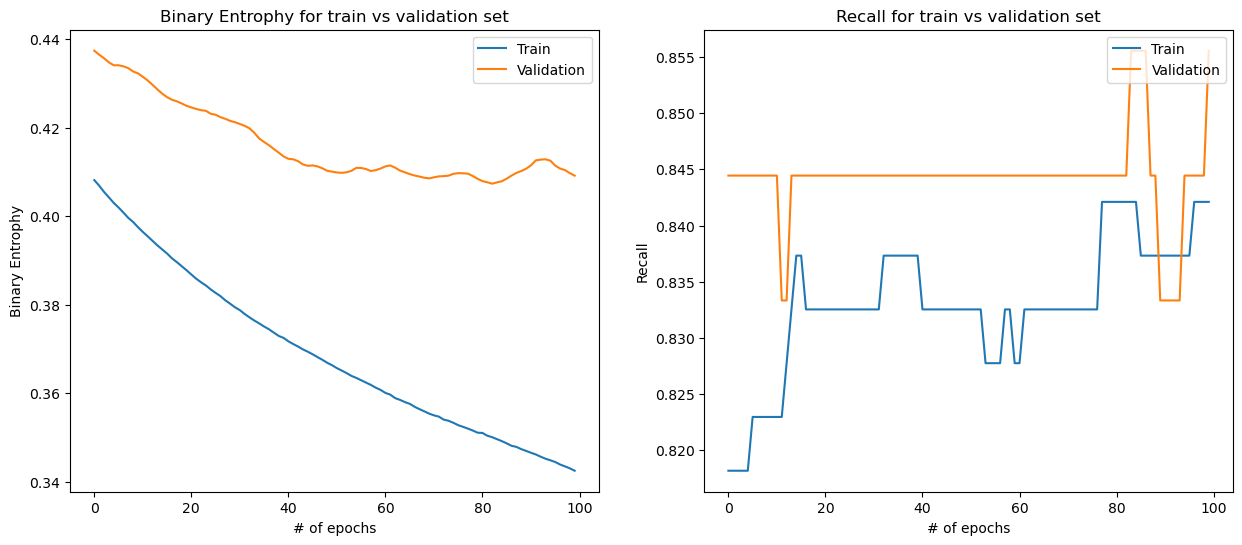

In [35]:


fig, axs = plt.subplots(1,2,
                        figsize=(15, 6),
                        gridspec_kw={'hspace': 0.5, 'wspace': 0.2}) 
(ax1, ax2) = axs
# Binary Entrophy
ax1.plot(h.history['loss'], label='Train')
ax1.plot(h.history['val_loss'], label='Validation')
ax1.set_title('Binary Entrophy for train vs validation set')
ax1.legend(loc="upper right")
ax1.set_xlabel("# of epochs")
ax1.set_ylabel("Binary Entrophy")

# Recall
ax2.plot(h.history['recall'], label='Train')
ax2.plot(h.history['val_recall'], label='Validation')
ax2.set_title('Recall for train vs validation set')
ax2.legend(loc="upper right")
ax2.set_xlabel("# of epochs")
ax2.set_ylabel("Recall")

### Accuracy

In [43]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Loss", loss, "Accuracy:", acc)

Loss 0.40912243723869324 Accuracy: 0.855555534362793


### Evaluation

In [45]:
y_pred = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1], dtype=int64)

In [46]:
y_true = np.argmax(y_test, axis=1)
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1], dtype=int64)

In [47]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        65
           1       0.77      0.68      0.72        25

    accuracy                           0.86        90
   macro avg       0.83      0.80      0.81        90
weighted avg       0.85      0.86      0.85        90



In [49]:
model_matrix = confusion_matrix(y_true, y_pred)
model_matrix

array([[60,  5],
       [ 8, 17]], dtype=int64)

<AxesSubplot:>

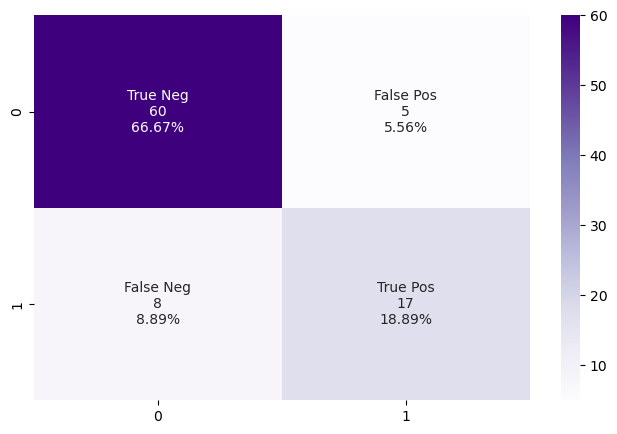

In [50]:
# Visualize
fig, ax = plt.subplots(figsize=(8,5))

# setting variables
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in model_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in model_matrix.flatten()/np.sum(model_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(model_matrix, annot=labels, fmt='', cmap='Purples')

In [52]:
Recall2    = recall_score(y_true, y_pred)
Recall2

0.68

After playing with different hyperparameters combination value, we were able to produce a model thats not overfit nor underfit and at the same time we minimize the recall score.

Let's try using GridSearchCV if we can reproduce the same hyperpameter and recall score.

# Hyperpameter Tune in
We will use GridSearchCV to find the optimal hyperparameter value, however using this method is very CPU computational expensive (there's a technique that can improve training/gridsearch speed but we will not do it here). We will do  search each hyperameter individually with minimum search value.

In [ ]:
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV


import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import numpy as np

In [ ]:
data = pd.read_csv('heart_failure.csv')
# print(data.info())

# print('Classes and number of values in the dataset',Counter(data['death_event']))
 
y = data["death_event"]
x = data[['age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction','high_blood_pressure','platelets','serum_creatinine','serum_sodium','sex','smoking','time']]

x  = pd.get_dummies(x)

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)



In [ ]:
ct = ColumnTransformer([("numeric", StandardScaler(), 
                        X_train.columns 
                        )])

In [ ]:
X_train = ct.fit_transform(X_train)
# X_train
X_test = ct.transform(X_test)
# X_test

In [ ]:
le= LabelEncoder()

In [ ]:
Y_train = le.fit_transform(Y_train.astype(str))
Y_test = le.transform(Y_test.astype(str))

In [ ]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [ ]:
model = Sequential()

In [ ]:
model.add(InputLayer(input_shape=(X_train.shape[1],)))

In [ ]:
model.add(Dense(12, activation='relu'))

In [ ]:
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs = 50, batch_size = 2, verbose=1)

In [ ]:
loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print("Loss", loss, "Accuracy:", acc)

In [ ]:
y_estimate = model.predict(X_test, verbose=0)
# y_estimate

In [ ]:
y_estimate = np.argmax(y_estimate, axis=1)
y_estimate

In [ ]:
y_true = np.argmax(Y_test, axis=1)

In [ ]:
y_true

In [ ]:
print(classification_report(y_true, y_estimate))

In [ ]:
# Function to create model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],)))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# fix random seed for reproducibility
seed = 7
tf.random.set_seed(seed)

In [ ]:
# create model
model = KerasClassifier(model=create_model, verbose=0)

In [ ]:
# define the grid search parameters
batch_size = [10, 20]
epochs = [11, 21]

param_grid = dict(
                  batch_size = batch_size,
                  epochs = epochs
                  )

In [ ]:
grid = GridSearchCV(estimator = model, 
                    param_grid = param_grid,
                    n_jobs=-1,
                    verbose=1, 
                    cv=3)


grid_result = grid.fit(X_train, Y_train)

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))